In [ ]:
# !kaggle datasets download -d blastchar/telco-customer-churn

In [1]:
import pandas as pd
import numpy as np
import xgboost as xgb
import os
import time
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import balanced_accuracy_score, roc_auc_score, make_scorer
from sklearn.metrics import confusion_matrix, plot_confusion_matrix

In [2]:
df = pd.read_csv('Telco-Customer-Churn.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


In [3]:
df.sample(10)

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
4183,6917-IAYHD,Male,0,No,Yes,1,No,No phone service,DSL,No,...,No,Yes,No,No,Month-to-month,No,Mailed check,33.60,33.6,No
607,8672-OAUPW,Male,0,No,Yes,51,Yes,No,DSL,No,...,No,Yes,No,No,One year,No,Credit card (automatic),47.85,2356.75,No
46,5948-UJZLF,Male,0,No,No,2,Yes,No,DSL,No,...,No,No,No,No,Month-to-month,No,Mailed check,49.25,97,No
3635,5296-PSYVW,Female,0,Yes,No,72,Yes,Yes,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Electronic check,24.55,1750.7,No
6440,2809-ZMYOQ,Female,0,No,No,32,Yes,Yes,Fiber optic,No,...,Yes,No,Yes,Yes,Month-to-month,Yes,Electronic check,101.35,3334.9,No
3312,9122-UMROB,Male,0,No,No,1,Yes,No,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,Month-to-month,No,Mailed check,20.30,20.3,No
2772,3470-OBUET,Female,0,Yes,Yes,67,Yes,Yes,DSL,Yes,...,No,Yes,Yes,No,Two year,No,Credit card (automatic),74.00,4868.4,No
5754,1431-CYWMH,Female,0,Yes,Yes,22,Yes,No,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,Month-to-month,No,Bank transfer (automatic),19.05,454.05,No
6970,8083-YTZES,Male,0,No,No,4,Yes,Yes,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,74.35,265.35,Yes
4483,3873-WOSBC,Male,0,Yes,No,67,Yes,Yes,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Credit card (automatic),25.60,1784.9,No


<AxesSubplot:>

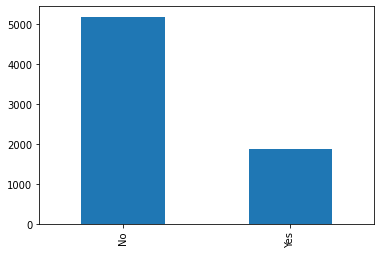

In [4]:
df.Churn.value_counts().plot(kind='bar')

<AxesSubplot:xlabel='gender'>

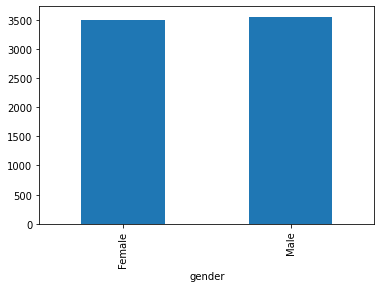

In [5]:
df.groupby('gender')['Churn'].count().plot(kind='bar')

In [6]:
df.PhoneService.value_counts()

Yes    6361
No      682
Name: PhoneService, dtype: int64

In [7]:
df.loc[(df.TotalCharges == ' ', 'TotalCharges')] = '0'

In [8]:
df[df.TotalCharges == '0']

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
488,4472-LVYGI,Female,0,Yes,Yes,0,No,No phone service,DSL,Yes,...,Yes,Yes,Yes,No,Two year,Yes,Bank transfer (automatic),52.55,0,No
753,3115-CZMZD,Male,0,No,Yes,0,Yes,No,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,20.25,0,No
936,5709-LVOEQ,Female,0,Yes,Yes,0,Yes,No,DSL,Yes,...,Yes,No,Yes,Yes,Two year,No,Mailed check,80.85,0,No
1082,4367-NUYAO,Male,0,Yes,Yes,0,Yes,Yes,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,25.75,0,No
1340,1371-DWPAZ,Female,0,Yes,Yes,0,No,No phone service,DSL,Yes,...,Yes,Yes,Yes,No,Two year,No,Credit card (automatic),56.05,0,No
3331,7644-OMVMY,Male,0,Yes,Yes,0,Yes,No,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,19.85,0,No
3826,3213-VVOLG,Male,0,Yes,Yes,0,Yes,Yes,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,25.35,0,No
4380,2520-SGTTA,Female,0,Yes,Yes,0,Yes,No,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,20.00,0,No
5218,2923-ARZLG,Male,0,Yes,Yes,0,Yes,No,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,One year,Yes,Mailed check,19.70,0,No
6670,4075-WKNIU,Female,0,Yes,Yes,0,Yes,Yes,DSL,No,...,Yes,Yes,Yes,No,Two year,No,Mailed check,73.35,0,No


In [9]:
df.TotalCharges = pd.to_numeric(df.TotalCharges)

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


In [11]:
df.replace(' ', '_', regex=True, inplace=True)
df.sample(10)

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
5975,1522-VVDMG,Male,0,Yes,Yes,7,Yes,No,Fiber_optic,No,...,No,Yes,Yes,No,Month-to-month,Yes,Electronic_check,89.75,608.80,Yes
4678,3006-XIMLN,Female,0,No,Yes,2,Yes,Yes,Fiber_optic,No,...,No,No,Yes,Yes,Month-to-month,Yes,Bank_transfer_(automatic),94.20,193.80,Yes
4784,1622-HSHSF,Female,0,No,No,1,Yes,No,No,No_internet_service,...,No_internet_service,No_internet_service,No_internet_service,No_internet_service,Month-to-month,Yes,Mailed_check,19.55,19.55,No
3662,6410-LEFEN,Female,0,No,No,9,Yes,No,DSL,No,...,No,No,No,No,Month-to-month,No,Electronic_check,45.15,416.45,Yes
5714,6108-OQZDQ,Female,0,Yes,Yes,4,Yes,Yes,Fiber_optic,No,...,No,No,Yes,Yes,Month-to-month,Yes,Electronic_check,97.95,384.50,Yes
1103,7722-CVFXN,Male,0,Yes,Yes,54,Yes,Yes,Fiber_optic,No,...,No,Yes,Yes,Yes,One_year,Yes,Electronic_check,105.20,5637.85,No
4594,4658-HCOHW,Female,0,Yes,Yes,21,Yes,No,Fiber_optic,No,...,Yes,Yes,Yes,Yes,Month-to-month,Yes,Electronic_check,102.80,2110.15,Yes
2828,8559-WNQZS,Male,0,No,No,1,Yes,No,No,No_internet_service,...,No_internet_service,No_internet_service,No_internet_service,No_internet_service,Two_year,No,Mailed_check,20.45,20.45,No
4943,4973-MGTON,Female,0,Yes,No,71,Yes,No,DSL,Yes,...,Yes,Yes,Yes,Yes,Two_year,Yes,Credit_card_(automatic),84.40,5969.30,No
1180,4835-YSJMR,Male,0,No,No,39,Yes,No,DSL,No,...,No,Yes,No,No,Two_year,Yes,Bank_transfer_(automatic),49.80,1971.15,No


In [12]:
X = df.drop(['customerID', 'Churn'], axis=1).copy()
y = df.Churn.copy()
X.shape, y.shape

((7043, 19), (7043,))

In [13]:
X.dtypes

gender               object
SeniorCitizen         int64
Partner              object
Dependents           object
tenure                int64
PhoneService         object
MultipleLines        object
InternetService      object
OnlineSecurity       object
OnlineBackup         object
DeviceProtection     object
TechSupport          object
StreamingTV          object
StreamingMovies      object
Contract             object
PaperlessBilling     object
PaymentMethod        object
MonthlyCharges      float64
TotalCharges        float64
dtype: object

In [14]:
X_encoded = pd.get_dummies(X, columns=['gender',
                                       'SeniorCitizen',
                                       'Partner',
                                       'Dependents',
                                       'PhoneService',
                                       'MultipleLines',
                                       'InternetService',
                                       'OnlineSecurity',
                                       'OnlineBackup',
                                       'DeviceProtection',
                                       'TechSupport',
                                       'StreamingTV',
                                       'StreamingMovies',
                                       'Contract',
                                       'PaperlessBilling',
                                       'PaymentMethod',
                                      ])
X_encoded.sample(10)

,tenure,MonthlyCharges,TotalCharges,gender_Female,gender_Male,SeniorCitizen_0,SeniorCitizen_1,Partner_No,Partner_Yes,Dependents_No,...,StreamingMovies_Yes,Contract_Month-to-month,Contract_One_year,Contract_Two_year,PaperlessBilling_No,PaperlessBilling_Yes,PaymentMethod_Bank_transfer_(automatic),PaymentMethod_Credit_card_(automatic),PaymentMethod_Electronic_check,PaymentMethod_Mailed_check
4001,45,109.75,4900.65,0,1,1,0,0,1,0,...,1,0,0,1,0,1,1,0,0,0
2960,22,100.75,2095.00,0,1,1,0,1,0,1,...,1,1,0,0,0,1,0,0,1,0
6055,6,55.00,340.40,1,0,1,0,1,0,1,...,1,1,0,0,0,1,0,0,1,0
3315,66,107.35,7051.95,0,1,0,1,0,1,1,...,1,0,1,0,0,1,1,0,0,0
3478,23,78.55,1843.05,1,0,1,0,1,0,1,...,1,0,1,0,0,1,0,0,1,0
2771,13,63.15,816.80,1,0,1,0,0,1,0,...,1,1,0,0,0,1,0,0,0,1
4062,1,70.50,70.50,1,0,1,0,1,0,1,...,0,1,0,0,1,0,0,0,1,0
1331,1,25.15,25.15,1,0,1,0,1,0,1,...,0,1,0,0,0,1,0,0,0,1
2592,12,19.45,246.25,1,0,1,0,1,0,1,...,0,1,0,0,1,0,0,0,0,1
2425,26,20.30,511.25,0,1,1,0,1,0,1,...,0,1,0,0,0,1,0,0,1,0


y.unique()

In [24]:
y = y.map(lambda x: 1 if x == 'Yes' else 0)

In [19]:
X.info(), y.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 19 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gender            7043 non-null   object 
 1   SeniorCitizen     7043 non-null   int64  
 2   Partner           7043 non-null   object 
 3   Dependents        7043 non-null   object 
 4   tenure            7043 non-null   int64  
 5   PhoneService      7043 non-null   object 
 6   MultipleLines     7043 non-null   object 
 7   InternetService   7043 non-null   object 
 8   OnlineSecurity    7043 non-null   object 
 9   OnlineBackup      7043 non-null   object 
 10  DeviceProtection  7043 non-null   object 
 11  TechSupport       7043 non-null   object 
 12  StreamingTV       7043 non-null   object 
 13  StreamingMovies   7043 non-null   object 
 14  Contract          7043 non-null   object 
 15  PaperlessBilling  7043 non-null   object 
 16  PaymentMethod     7043 non-null   object 


(None, 0)

In [25]:
sum(y)/len(y)

0.2653698707936959

In [37]:
y.dtypes

dtype('int64')

In [39]:
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, random_state=46, stratify=y)

In [40]:
X_train.shape, X_test.shape

((5282, 46), (1761, 46))

In [41]:
X_test

,tenure,MonthlyCharges,TotalCharges,gender_Female,gender_Male,SeniorCitizen_0,SeniorCitizen_1,Partner_No,Partner_Yes,Dependents_No,...,StreamingMovies_Yes,Contract_Month-to-month,Contract_One_year,Contract_Two_year,PaperlessBilling_No,PaperlessBilling_Yes,PaymentMethod_Bank_transfer_(automatic),PaymentMethod_Credit_card_(automatic),PaymentMethod_Electronic_check,PaymentMethod_Mailed_check
3293,5,64.00,370.25,1,0,1,0,1,0,1,...,1,1,0,0,0,1,0,0,1,0
6414,40,25.25,1006.90,0,1,1,0,0,1,0,...,0,0,0,1,1,0,0,1,0,0
2042,28,64.45,1867.60,1,0,0,1,1,0,1,...,0,1,0,0,1,0,1,0,0,0
3022,2,19.95,38.15,1,0,1,0,1,0,1,...,0,1,0,0,1,0,0,0,0,1
393,19,19.90,367.55,1,0,1,0,1,0,1,...,0,1,0,0,1,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6045,38,19.60,763.10,1,0,1,0,0,1,0,...,0,0,1,0,1,0,0,1,0,0
3727,3,96.60,291.90,1,0,1,0,1,0,1,...,1,1,0,0,0,1,0,0,1,0
1401,4,99.80,442.85,1,0,0,1,1,0,1,...,1,1,0,0,0,1,0,1,0,0
1734,9,45.40,418.80,0,1,1,0,1,0,1,...,1,1,0,0,0,1,0,0,1,0


In [42]:
sum(y_train)/len(y_train)

0.2654297614539947

In [43]:
sum(y_test)/len(y_test)

0.26519023282226006

In [51]:
clf_xgb = xgb.XGBClassifier(objective='binary:logistic', missing=None, seed=46)
clf_xgb.fit(X_train, y_train,
           verbose=True,
           early_stopping_rounds=10,
           eval_metric='aucpr',
           eval_set=[(X_test, y_test)])

[0]	validation_0-aucpr:0.61048
Will train until validation_0-aucpr hasn't improved in 10 rounds.
[1]	validation_0-aucpr:0.62304
[2]	validation_0-aucpr:0.63182
[3]	validation_0-aucpr:0.64072
[4]	validation_0-aucpr:0.65335
[5]	validation_0-aucpr:0.65763
[6]	validation_0-aucpr:0.65767
[7]	validation_0-aucpr:0.65631
[8]	validation_0-aucpr:0.65562
[9]	validation_0-aucpr:0.65436
[10]	validation_0-aucpr:0.64725
[11]	validation_0-aucpr:0.65011
[12]	validation_0-aucpr:0.65241
[13]	validation_0-aucpr:0.65252
[14]	validation_0-aucpr:0.65072
[15]	validation_0-aucpr:0.65163
[16]	validation_0-aucpr:0.65085
Stopping. Best iteration:
[6]	validation_0-aucpr:0.65767



XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=None, monotone_constraints='()',
              n_estimators=100, n_jobs=0, num_parallel_tree=1, random_state=46,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=46,
              subsample=1, tree_method='exact', validate_parameters=1,
              verbosity=None)

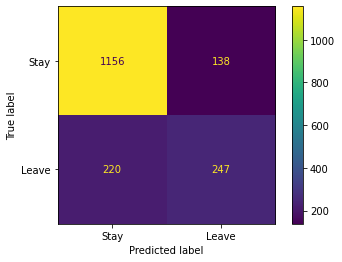

In [52]:
plot_confusion_matrix(clf_xgb,
                     X_test,
                     y_test,
                     values_format='d',
                     display_labels=['Stay', 'Leave'])

In [60]:
# GridSearchCV
param_grid1 = {
    'max_depth': [3, 4, 5],
    'learning_rate': [.1, .01, .05],
    'gamma': [0, .25, 1.],
    'reg_lambda': [0, 1., 10.],
    'scale_pos_weight': [1, 3, 5]
}

param_grid2 = {
    'max_depth': [3,4],
    'learning_rate': [.1, .5, 1.],
    'gamma': [1.],
    'reg_lambda': [10., 20, 100],
    'scale_pos_weight': [3]
}

In [56]:
optimal_params = GridSearchCV(
    estimator = xgb.XGBClassifier(objective='binary:logistic',
                                 seed=46,
                                 subsample=.9,
                                 colsample_bytree=.5),
    param_grid=param_grid1,
    scoring='roc_auc',
    verbose=1,
    n_jobs=10,
    cv=3
)

optimal_params.fit(X_train, y_train,
                  early_stopping_rounds=10,
                  eval_metric='auc',
                  eval_set=[(X_test, y_test)],
                  verbose=False)

print(optimal_params.best_params_)

Fitting 3 folds for each of 243 candidates, totalling 729 fits


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  40 tasks      | elapsed:    0.8s
[Parallel(n_jobs=10)]: Done 340 tasks      | elapsed:    5.1s
[Parallel(n_jobs=10)]: Done 710 out of 729 | elapsed:   11.1s remaining:    0.3s
[Parallel(n_jobs=10)]: Done 729 out of 729 | elapsed:   11.5s finished


{'gamma': 1.0, 'learning_rate': 0.1, 'max_depth': 3, 'reg_lambda': 10.0, 'scale_pos_weight': 3}


In [61]:
optimal_params = GridSearchCV(
    estimator = xgb.XGBClassifier(objective='binary:logistic',
                                 seed=46,
                                 subsample=.9,
                                 colsample_bytree=.5),
    param_grid=param_grid2,
    scoring='roc_auc',
    verbose=1,
    n_jobs=10,
    cv=3
)

optimal_params.fit(X_train, y_train,
                  early_stopping_rounds=10,
                  eval_metric='auc',
                  eval_set=[(X_test, y_test)],
                  verbose=False)

print(optimal_params.best_params_)

Fitting 3 folds for each of 18 candidates, totalling 54 fits


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  35 out of  54 | elapsed:    0.6s remaining:    0.3s
[Parallel(n_jobs=10)]: Done  54 out of  54 | elapsed:    0.7s finished


{'gamma': 1.0, 'learning_rate': 0.1, 'max_depth': 3, 'reg_lambda': 10.0, 'scale_pos_weight': 3}


In [62]:
clf_xgb = xgb.XGBClassifier(seed=46,
                           objective='binary:logistic',
                           gamma=1.,
                           learning_rate=.1,
                           max_depth=3,
                           reg_lambda=10,
                           scale_pos_weight=3,
                           subsample=.9,
                           colsample_bytree=.5)
clf_xgb.fit(X_train, y_train,
           verbose=True,
           early_stopping_rounds=10,
           eval_metric='aucpr',
           eval_set=[(X_test, y_test)])

[0]	validation_0-aucpr:0.57050
Will train until validation_0-aucpr hasn't improved in 10 rounds.
[1]	validation_0-aucpr:0.57455
[2]	validation_0-aucpr:0.59003
[3]	validation_0-aucpr:0.59030
[4]	validation_0-aucpr:0.59110
[5]	validation_0-aucpr:0.59143
[6]	validation_0-aucpr:0.59044
[7]	validation_0-aucpr:0.60616
[8]	validation_0-aucpr:0.61551
[9]	validation_0-aucpr:0.61655
[10]	validation_0-aucpr:0.62998
[11]	validation_0-aucpr:0.63633
[12]	validation_0-aucpr:0.63675
[13]	validation_0-aucpr:0.63875
[14]	validation_0-aucpr:0.63891
[15]	validation_0-aucpr:0.64092
[16]	validation_0-aucpr:0.63959
[17]	validation_0-aucpr:0.64050
[18]	validation_0-aucpr:0.64460
[19]	validation_0-aucpr:0.64723
[20]	validation_0-aucpr:0.64769
[21]	validation_0-aucpr:0.64791
[22]	validation_0-aucpr:0.64831
[23]	validation_0-aucpr:0.65092
[24]	validation_0-aucpr:0.65299
[25]	validation_0-aucpr:0.65387
[26]	validation_0-aucpr:0.65357
[27]	validation_0-aucpr:0.65540
[28]	validation_0-aucpr:0.65469
[29]	validation_

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.5, gamma=1.0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=0, num_parallel_tree=1, random_state=46,
              reg_alpha=0, reg_lambda=10, scale_pos_weight=3, seed=46,
              subsample=0.9, tree_method='exact', validate_parameters=1,
              verbosity=None)

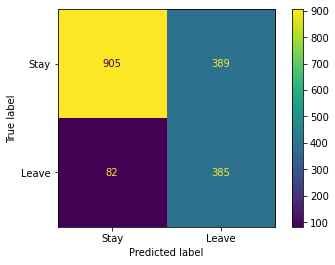

In [63]:
plot_confusion_matrix(clf_xgb,
                     X_test,
                     y_test,
                     values_format='d',
                     display_labels=['Stay', 'Leave'])

In [64]:
clf_xgb = xgb.XGBClassifier(seed=46,
                           objective='binary:logistic',
                           gamma=1.,
                           learning_rate=.1,
                           max_depth=3,
                           reg_lambda=10,
                           scale_pos_weight=3,
                           subsample=.9,
                           colsample_bytree=.5)
clf_xgb.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.5, gamma=1.0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=0, num_parallel_tree=1, random_state=46,
              reg_alpha=0, reg_lambda=10, scale_pos_weight=3, seed=46,
              subsample=0.9, tree_method='exact', validate_parameters=1,
              verbosity=None)

In [73]:
bst = clf_xgb.get_booster()
for importance_type in ('weight', 'gain', 'cover', 'total_gain', 'total_cover'):
    print('%s: '%importance_type, bst.get_score(importance_type=importance_type))
    
node_params = {'shape': 'box',
              'style': 'filled, rounded',
              'fillcolor': '#87cbe'}
leaf_params = {'shape': 'box',
              'style': 'filled',
              'fillcolor': '#e48038'}

# Need install graphviz in system by "sudo apt-get install graphviz"
# xgb.to_graphviz(clf_xgb, num_trees=0, size='10,10',
#                condition_node_params=node_params,
#                leaf_node_params=leaf_params)

weight:  {'OnlineSecurity_No': 18, 'tenure': 108, 'InternetService_Fiber_optic': 26, 'InternetService_DSL': 5, 'TechSupport_No': 13, 'TotalCharges': 141, 'Contract_Month-to-month': 17, 'MonthlyCharges': 110, 'Contract_One_year': 6, 'PaymentMethod_Electronic_check': 22, 'OnlineBackup_No': 13, 'StreamingMovies_Yes': 6, 'StreamingTV_No': 4, 'StreamingTV_Yes': 11, 'Contract_Two_year': 17, 'SeniorCitizen_0': 12, 'SeniorCitizen_1': 6, 'PaperlessBilling_No': 18, 'PhoneService_Yes': 3, 'PaperlessBilling_Yes': 5, 'InternetService_No': 3, 'Partner_No': 8, 'PaymentMethod_Credit_card_(automatic)': 13, 'MultipleLines_No': 20, 'Dependents_No': 10, 'Dependents_Yes': 2, 'PaymentMethod_Mailed_check': 10, 'OnlineSecurity_Yes': 3, 'OnlineBackup_Yes': 5, 'DeviceProtection_No': 1, 'PhoneService_No': 9, 'StreamingTV_No_internet_service': 1, 'MultipleLines_Yes': 4, 'StreamingMovies_No': 4, 'PaymentMethod_Bank_transfer_(automatic)': 5, 'gender_Female': 5, 'TechSupport_Yes': 5, 'gender_Male': 2, 'Partner_Yes':

ExecutableNotFound: failed to execute ['dot', '-Tsvg'], make sure the Graphviz executables are on your systems' PATH